In [15]:
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay
import numpy as np
from sklearn.metrics import RocCurveDisplay
from MTCFeatures import MTCFeatureLoader
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from fractions import Fraction

### Récupération des données

In [16]:
fl = MTCFeatureLoader('MTC-FS-INST-2.0')
seqs = fl.sequences()

### Récupération des informations des features de chaque séquence.
On les met sous forme de dataframe pandas.

In [17]:
%%time
phrase_data = []
for ii, x in enumerate(seqs):
    phrase_data.append({
        'id': x['id'],
        **x['features']
    })

CPU times: total: 7.89 s
Wall time: 10.7 s


In [18]:
df = pd.DataFrame(phrase_data)

### Création des sous sequences
Taille et step à définir comme on veut.

In [19]:
size = 4 #taille des sous sequences 
step = size // 2 #décalage

subsequences = []
labels = []
ids = []
list_columns = []

for col in df.columns:
    if col != 'id' and df[col].apply(lambda x: isinstance(x, list)).all():
        list_columns.append(col) #prend les colonnes qui sont composées de liste

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    song_id = row['id']
    sequence_length = len(row['scaledegree'])

    if sequence_length == 0:
        continue # Passage a la sequence suivante si ça taille est de 0
    
    #Parcours de séquences pour créer des sous-séquences.
    start_idx = 0
    while start_idx + size <= sequence_length: 
        end_idx = start_idx + size

        subseq = {}
        for col in list_columns:
            subseq[col] = row[col][start_idx:end_idx]
        if len(subseq['scaledegree']) == size:
            label = subseq['phrase_end'][-1] #Utilisation de la dernière valeur de phrase_end, pour labelliser la sous-séquence.
            subsequences.append(subseq)
            labels.append(label)
            ids.append(song_id)

        start_idx += step  
    
    # Dernière sous séquences
    if start_idx < sequence_length:
        end_idx = sequence_length

        subseq = {}
        for col in list_columns:
            subseq[col] = row[col][start_idx:end_idx]
        if len(subseq['scaledegree']) == size:
            label = subseq['phrase_end'][-1]
            subsequences.append(subseq)
            labels.append(label)
            ids.append(song_id)

subsequences = pd.DataFrame(subsequences)
subsequences['id'] = ids
subsequences['label'] = labels

100%|██████████| 18109/18109 [02:13<00:00, 135.54it/s]


### Visualisation des sous séquences

In [20]:
subsequences

,scaledegree,scaledegreespecifier,tonic,mode,metriccontour,imaweight,pitch40,midipitch,diatonicpitch,diatonicinterval,...,lbdm_sioi,lbdm_srest,lbdm_rpitch,lbdm_rioi,lbdm_rrest,lbdm_boundarystrength,durationcontour,IOR_frac,id,label
0,"[3, 1, 6, 5]","[M, P, M, P]","[C, C, C, C]","[major, major, major, major]","[None, -, -, +]","[0.798013, 0.663907, 0.150662, 0.945364]","[135, 123, 112, 106]","[64, 60, 57, 55]","[30, 28, 26, 25]","[None, -2, -2, -1]",...,"[None, 0.08928571428571427, 0.053571428571428575, 0.28124999999999994]","[None, 0.0, 0.0, 0.0]","[None, 0.1111111111111111, 0.14285714285714285, 0.3333333333333333]","[None, 0.3333333333333333, 0.0, 0.2]","[None, 0.0, 0.0, 0.0]","[None, 0.057127851140456175, 0.04239195678271308, 0.22645933373349336]","[None, -, =, +]","[None, 1/2, 1, 3/2]",NLB125814_01,False
1,"[6, 5, 1, 1]","[M, P, P, P]","[C, C, C, C]","[major, major, major, major]","[-, +, -, +]","[0.150662, 0.945364, 0.013245, 0.524834]","[112, 106, 123, 123]","[57, 55, 60, 60]","[26, 25, 28, 28]","[-2, -1, 3, 0]",...,"[0.053571428571428575, 0.28124999999999994, 0.14732142857142858, 0.3214285714285714]","[0.0, 0.0, 0.0, 0.0]","[0.14285714285714285, 0.3333333333333333, 0.7142857142857143, 0.5]","[0.0, 0.2, 0.5, 0.6]","[0.0, 0.0, 0.0, 0.0]","[0.04239195678271308, 0.22645933373349336, 0.07366071428571429, 0.17710084033613444]","[=, +, -, +]","[1, 3/2, 1/3, 4]",NLB125814_01,False
2,"[1, 1, 2, 1]","[P, P, M, P]","[C, C, C, C]","[major, major, major, major]","[-, +, +, -]","[0.013245, 0.524834, 0.93543, 0.673841]","[123, 123, 129, 123]","[60, 60, 62, 60]","[28, 28, 29, 28]","[3, 0, 1, -1]",...,"[0.14732142857142858, 0.3214285714285714, 0.17857142857142855, 0.08928571428571427]","[0.0, 0.0, 0.0, 0.0]","[0.7142857142857143, 0.5, 0.0, 0.0]","[0.5, 0.6, 0.0, 0.3333333333333333]","[0.0, 0.0, 0.0, 0.0]","[0.07366071428571429, 0.17710084033613444, 0.08928571428571427, 0.04464285714285714]","[-, +, =, -]","[1/3, 4, 1, 1/2]",NLB125814_01,False
3,"[2, 1, 2, 3]","[M, P, M, M]","[C, C, C, C]","[major, major, major, major]","[+, -, -, +]","[0.93543, 0.673841, 0.195364, 0.812914]","[129, 123, 129, 135]","[62, 60, 62, 64]","[29, 28, 29, 30]","[1, -1, 1, 1]",...,"[0.17857142857142855, 0.08928571428571427, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.45454545454545453]","[0.0, 0.3333333333333333, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[0.08928571428571427, 0.04464285714285714, 0.014896867838044309, 0.10427807486631016]","[=, -, =, =]","[1, 1/2, 1, 1]",NLB125814_01,False
4,"[2, 3, 6, 5]","[M, M, M, P]","[C, C, C, C]","[major, major, major, major]","[-, +, -, +]","[0.195364, 0.812914, 0.162252, 0.627483]","[129, 135, 112, 106]","[62, 64, 57, 55]","[29, 30, 26, 25]","[1, 1, -4, -1]",...,"[0.0, 0.0, 0.08928571428571427, 0.17857142857142855]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.45454545454545453, 0.45454545454545453, 0.5]","[0.0, 0.0, 0.0, 0.3333333333333333]","[0.0, 0.0, 0.0, 0.0]","[0.014896867838044309, 0.10427807486631016, 0.0759262796027502, 0.08928571428571427]","[=, =, =, +]","[1, 1, 1, 2]",NLB125814_01,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625660,"[5, 6, 5, 3]","[P, M, P, M]","[G, G, G, G]","[major, major, major, major]","[+, -, =, +]","[0.855851, 0.212766, 0.129787, 0.970213]","[169, 175, 169, 158]","[74, 76, 74, 71]","[32, 33, 32, 30]","[0, 1, -1, -2]",...,"[0.0, 0.0, 0.15873015873015875, 0.634920634920635]","[0.0, 0.0, 0.0, 0.0]","[0.5, 0.0, 0.14285714285714285, 0.1111111111111111]","[0.0, 0.0, 0.0, 0.3333333333333333]","[0.0, 0.0, 0.0, 0.0]","[0.019782608695652175, 0.005652173913043478, 0.09443754313319531, 0.34603519668737065]","[=, =, =, +]","[1, 1, 1, 2]",NLB179590_01,False
625661,"[5, 3, 1, 2]","[P, M, P, M]","[G, G, G, G]","[major, major, major, major]","[=, +, -, +]","[0.129787, 0.970213, 0.410106, 0.892553]","[169, 158, 146, 152]","[74, 71, 67, 69]","[32, 30, 28, 29]","[-1, -2, -2, 1]",...,"[0.15873015873015875, 0.634920634920635, 0.15873015873015875, 0.0]","[0.0, 0.0, 0.0, 0.0]

### Choix des features à utiliser
Sélection des features, puis on étend les listes de sous-séquences. 

In [21]:
feature_columns = ["scaledegree", "duration", "midipitch", "beatstrength"]

feature_arrays = []
for idx, row in tqdm(subsequences.iterrows(), total=subsequences.shape[0], desc="Processing subsequences"):
    feature_vector = []
    for col in feature_columns:
        feature_vector.extend(row[col]) #on étend les sequences.
    feature_arrays.append(feature_vector)

features = np.array(feature_arrays)
labels = np.array(subsequences['label'])
ids = np.array(subsequences['id'])

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)



Processing subsequences: 100%|██████████| 625665/625665 [00:25<00:00, 24099.78it/s]


In [22]:
features

array([[3, 1, 6, ..., 0.5, 0.25, 1.0],
       [6, 5, 1, ..., 1.0, 0.125, 0.5],
       [1, 1, 2, ..., 0.5, 1.0, 0.5],
       ...,
       [1, 2, 3, ..., 1.0, 0.25, 0.25],
       [3, 4, 5, ..., 0.25, 0.5, 0.25],
       [5, 6, 7, ..., 0.25, 0.25, 1.0]], dtype=object)

### Formatage des données
Transformation des fractions en valeur numérique, transformation des données catégorielles et normalisation.


In [23]:
refactor = [4,5,6,7,8,9,10,11,12,13,14,15] #index des colones fraction a reformater

for x in refactor:
    features[:, x] = [
        float(Fraction(value)) if isinstance(value, str) and '/' in value else
        float(value) if value is not None else 0.0  # Remplacement des None par 0.0
        for value in features[:, x]
    ]
cat_columns = [] #index des colones catégorielles
num_columns = [] #index des colones numériques a normaliser

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False), cat_columns),  # Encodage catégoriel
        ('num', StandardScaler(), num_columns)  # Normalisation 
    ],
    remainder='passthrough' #données non modifiées
)

final_features = preprocessor.fit_transform(features)

### Division des données 
Division du jeu de données en un jeu d'entrainement et un jeu de test, pour entrainer et tester le modele, en utilisant la fonction `train_test_split()`.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    final_features,
    labels,
    test_size=1/3,
    stratify=labels)

### Initialisation du modèle
Ici nous utilisons le modèle RandomForestClassifier avec les paramètres par défaut.

In [25]:
model = RandomForestClassifier()
model.fit(X_train, y_train) #Apprentissage des données

RandomForestClassifier()

### Analyse des resultats du modèle
Affiche le rapport de classification avec les scores f1 et la matrice de confusion.

In [26]:
y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97    189064
           1       0.73      0.54      0.62     19491

    accuracy                           0.94    208555
   macro avg       0.84      0.76      0.79    208555
weighted avg       0.93      0.94      0.93    208555


Confusion Matrix:
[[185199   3865]
 [  8993  10498]]


### Analyse graphique des résultats du modèle
Matrice de confusion sous forme de graphique, courbe ROC

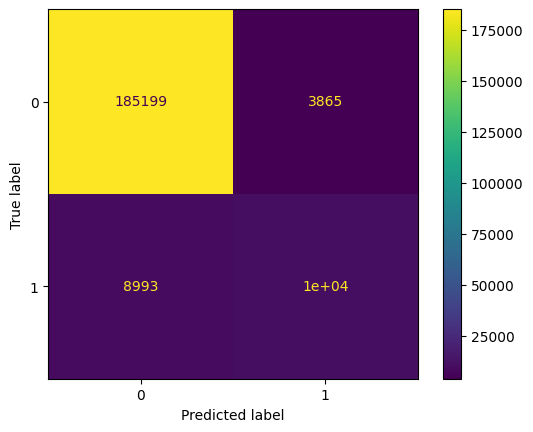

In [27]:
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
plt.show()

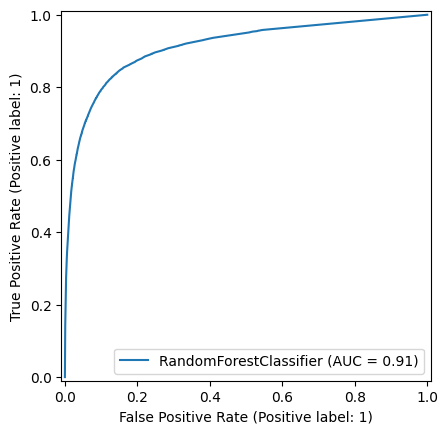

In [28]:
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()